In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, \
    GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from scipy.stats import spearmanr

In [3]:
dataset_path = '../data/model_data.h5'

# Load Data

In [4]:
data = pd.read_hdf(dataset_path, 'no_dummies')

In [5]:
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)
data

,Close,Volume,Open,High,Low,Consumption in mcf,Storage in mcf,US Gross Withdrawal in mcf,Other Gross Withdrawal in mcf,RSI,...,return_21d,return_42d,return_63d,target_1d,target_5d,target_10d,target_21d,year,month,weekday
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-09,2.107,108772.0,2.103,2.117,2.065,1953071.0,2478.0,2417498.0,93400.0,34.901425,...,-0.003584,-0.003797,-0.005916,-0.036070,-0.015267,-0.006449,0.007501,2012,4,0
2012-04-10,2.031,120126.0,2.111,2.125,2.025,1953071.0,2478.0,2417498.0,93400.0,30.556017,...,-0.006397,-0.004436,-0.006230,-0.023634,-0.008005,0.001807,0.009692,2012,4,1
2012-04-12,1.983,188668.0,1.976,2.068,1.972,1953071.0,2478.0,2417498.0,93400.0,28.170441,...,-0.006395,-0.005282,-0.006237,-0.001009,-0.007785,0.002641,0.011266,2012,4,3
2012-04-13,1.981,111947.0,1.982,1.999,1.959,1953071.0,2503.0,2417498.0,93400.0,28.072097,...,-0.007064,-0.005306,-0.005330,0.017668,-0.005512,0.009896,0.009795,2012,4,4
2012-04-16,2.016,115321.0,1.986,2.030,1.977,1953071.0,2503.0,2417498.0,93400.0,32.512260,...,-0.005926,-0.004447,-0.004609,-0.032242,-0.000894,0.012604,0.010299,2012,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,4.102,47082.0,4.025,4.187,4.010,2218011.0,2714.0,3396062.0,32500.0,79.676063,...,0.008724,0.008183,0.006137,-0.031936,-0.008278,-0.001029,-0.002451,2021,7,0
2021-07-27,3.971,40472.0,4.095,4.114,3.934,2218011.0,2714.0,3396062.0,32500.0,67.674236,...,0.006085,0.006827,0.005151,0.018383,0.002805,0.002933,-0.000895,2021,7,1
2021-07-28,4.044,3877.0,3.947,4.064,3.874,2218011.0,2714.0,3396062.0,32500.0,70.354143,...,0.005647,0.007474,0.005155,0.003709,0.005575,0.000370,0.001622,2021,7,2


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2330 entries, 2012-04-09 to 2021-07-30
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Close                          2330 non-null   float64
 1   Volume                         2330 non-null   float64
 2   Open                           2330 non-null   float64
 3   High                           2330 non-null   float64
 4   Low                            2330 non-null   float64
 5   Consumption in mcf             2330 non-null   float64
 6   Storage in mcf                 2330 non-null   float64
 7   US Gross Withdrawal in mcf     2330 non-null   float64
 8   Other Gross Withdrawal in mcf  2330 non-null   float64
 9   RSI                            2330 non-null   float64
 10  ATR                            2330 non-null   float64
 11  MACD                           2330 non-null   float64
 12  return_1d                     

In [7]:
columns_to_drop = ['Open', 'Close', 'Low', 'High', 'Volume']
y = data.filter(like='target')
X = data.drop(columns_to_drop, axis=1)
X = X.drop(y.columns, axis=1)

In [8]:

class MultipleTimeSeriesCV(BaseCrossValidator):
    """Generates tuples of train_idx, test_idx pairs"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('Date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['Date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.Date > days[train_start])
                              & (dates.Date <= days[train_end])].index
            test_idx = dates[(dates.Date > days[test_start])
                             & (dates.Date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [9]:
n_splits = 20
train_period_length = 300
test_period_length = 100
lookahead = 5

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

In [10]:
# Utilities functions

def display_score(scores):
    print('scores: ',scores)
    print('mean: ', scores.mean())
    print('standard deviation: ', scores.std())


def rank_correl(y, y_pred):
    return spearmanr(y, y_pred, axis=None)[0]

ic = make_scorer(rank_correl)


def get_cross_val_score(model, X, y, score_fun, cv, n_jobs=-1):
    cv_score = cross_val_score(estimator=model,
                           X=X,
                           y=y,
                           scoring=score_fun,
                           cv=cv,
                           n_jobs=n_jobs,
                           verbose=1)
    display_score(cv_score)

# Decision Tree Regressor

In [11]:
dt_reg = DecisionTreeRegressor(max_depth=None,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_features='auto')


In [12]:
get_cross_val_score(dt_reg, X, y, ic, cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [ 0.05725295  0.12998729  0.24037637 -0.10155339 -0.21020925  0.09080224
  0.20310089 -0.13462115  0.08363419  0.04656041  0.09420882  0.0774278
  0.02439095  0.11081834  0.07832519 -0.05583851  0.07089682  0.03800565
 -0.07064678  0.14909884]
mean:  0.046100883584037765
standard deviation:  0.10895457585937979


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.6s finished


# Random Forest Regressor

In [13]:
rf_reg = RandomForestRegressor(n_estimators=100,
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1,
                                random_state=None,
                                verbose=0,
                                warm_start=False)

In [14]:
get_cross_val_score(rf_reg, X, y, ic, cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [ 2.37072732e-01  1.40093376e-01  2.21538072e-01  8.83308646e-02
 -1.62102826e-01  3.31671870e-01  2.90356763e-01 -6.35694628e-02
  8.11338196e-02  1.76494103e-01  1.59779349e-01  1.49223933e-01
 -1.89376219e-05  1.71210422e-01  8.58699117e-03  1.56646196e-01
  6.06071288e-02  1.01738511e-01  8.62535391e-02  6.30804568e-02]
mean:  0.1149063449653289
standard deviation:  0.11361580914417195


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.4s finished


# Ada Boosting Regressor

In [15]:
ada_reg = AdaBoostRegressor(n_estimators=100,
                            loss='square')

In [16]:
get_cross_val_score(ada_reg, X, y['target_5d'], ic, cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [ 0.27216342  0.21133152  0.22248502  0.00490213 -0.28906806 -0.01734703
  0.33144695  0.0343554   0.02200844  0.17084048 -0.00071431  0.1364398
  0.21199051  0.19116039 -0.0373696  -0.13810465 -0.11426533  0.13197637
 -0.11194742  0.00957403]
mean:  0.06209290209642003
standard deviation:  0.1548196788531513


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.0s finished


# Gradient Boosting Regressor

In [17]:
grad_reg = GradientBoostingRegressor(n_estimators=250,
                                        max_depth=None,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        random_state=None,
                                        verbose=0,
                                        warm_start=False)

In [18]:
get_cross_val_score(grad_reg, X, y['target_5d'], ic, cv, n_jobs=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


scores:  [ 0.35602374  0.11761917  0.17818889  0.18843219 -0.44068694  0.11011597
 -0.01619289 -0.16817282  0.02164442  0.09921735 -0.07055011  0.33356336
  0.07482167  0.09148307  0.05446259 -0.03509814  0.1136337   0.15946882
 -0.00800482 -0.16687219]
mean:  0.04965485105623175
standard deviation:  0.17383628536813386


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   17.9s finished


It seems like that the best learner is the `ExtraTreesRegressor`. Let's fine tune it in order to find
the bests parameters

In [19]:
param_grid = {'n_estimators': [50, 100, 250],
              'max_depth': [5, 15, None],
              'min_samples_leaf': [5, 25, 100],
              'max_features': ['auto', 'sqrt', 'log2']}


In [20]:

from sklearn.model_selection import GridSearchCV

gridsearch_reg = GridSearchCV(estimator=rf_reg,
                              param_grid=param_grid,
                              scoring=ic,
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

In [21]:
gridsearch_reg.fit(X, y.target_5d.ravel())

Fitting 20 folds for each of 81 candidates, totalling 1620 fits


GridSearchCV(cv=MultipleTimeSeriesCV(lookahead=5, n_splits=20, shuffle=False,
           test_period_length=None, train_period_length=None),
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [5, 25, 100],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring=make_scorer(rank_correl),
             verbose=1)

In [22]:
best_learner = gridsearch_reg.best_estimator_

In [23]:
import pickle

best_model_filename = './best_tree_model.pkl'

with open(best_model_filename, 'wb') as file:
    pickle.dump(best_learner, file)


In [24]:
gridsearch_reg.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 25,
 'n_estimators': 50}

In [25]:
f'{gridsearch_reg.best_score_:.2f}'

'0.14'

## Evaluate the Best Model

In [26]:
for predicted, actual in zip(best_learner.predict(X.iloc[-15:]), y.target_5d.values[-15:]):
    print('Predicted: ', predicted)
    print('Actual: ', actual)
    print('Spread: ', np.abs(predicted - actual), end='\n\n')

Predicted:  0.003051592269457532
Actual:  0.0015953285074468138
Spread:  0.0014562637620107182

Predicted:  0.003823544656886324
Actual:  0.009555876643564165
Spread:  0.005732331986677841

Predicted:  0.003870588539287958
Actual:  0.01582964630890693
Spread:  0.011959057769618973

Predicted:  0.004205175136926554
Actual:  0.020656224280130253
Spread:  0.0164510491432037

Predicted:  0.003702059212105807
Actual:  0.020181341587396595
Spread:  0.01647928237529079

Predicted:  0.0038259831602524496
Actual:  0.016538315626423383
Spread:  0.012712332466170933

Predicted:  0.0031313404488542977
Actual:  0.004854597183057585
Spread:  0.0017232567342032874

Predicted:  0.0018199889430686998
Actual:  0.0042576045608697655
Spread:  0.0024376156178010657

Predicted:  0.0018209933294236224
Actual:  0.0027823752100966104
Spread:  0.000961381880672988

Predicted:  0.0008513260983186295
Actual:  -0.007297861266733707
Spread:  0.008149187365052336

Predicted:  -3.574702064727115e-05
Actual:  -0.00827

In [27]:
print(rank_correl(best_learner.predict(X.iloc[-15:]), y.target_5d.values[-15:]))


0.7810548248408075


## Parameters importance

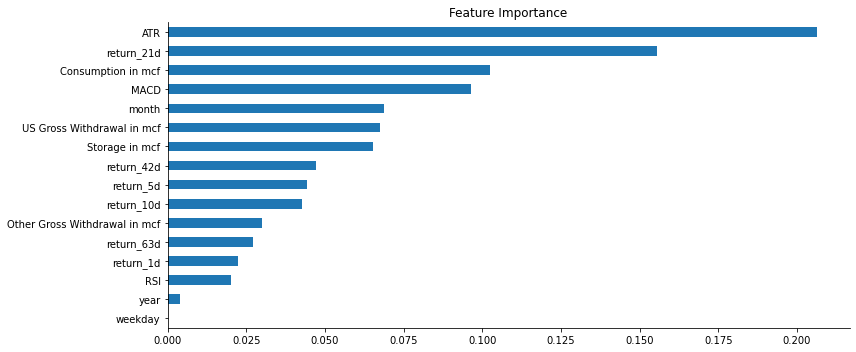

In [28]:

fig, ax = plt.subplots(figsize=(12,5))
(pd.Series(best_learner.feature_importances_, index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh(ax=ax, title='Feature Importance'))

sns.despine()

fig.tight_layout();
